<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/main/notebooks/GroundingDINO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GroundingDINO: 言語ベースの物体掲出
![image](https://github.com/IDEA-Research/GroundingDINO/blob/main/.asset/hero_figure.png?raw=true)
GroundingDINOレポジトリより
## ライセンス
- Liu, S., Zeng, Z., Ren, T., Li, F., Zhang, H., Yang, J., Li, C., Yang, J., Su, H., Zhu, J., & Zhang, L. (2023). Grounding DINO: Marrying DINO with Grounded Pre-Training for Open-Set Object Detection. In arXiv [cs.CV]. arXiv. http://arxiv.org/abs/2303.05499
- GroundingDINOレポジトリ
 - https://github.com/IDEA-Research/GroundingDINO
 - Apache-2.0
- 生け花サンプル画像
 - Marko Kafé, CC BY-SA 4.0 <https://creativecommons.org/licenses/by-sa/4.0>, via Wikimedia Commons
- 本ノートブック
 - CC-BY-NC-4.0

## 解説
DINOと呼ばれるTransformerベースの物体検出器に言語情報を統合したGrounding DINOを紹介します。Grounding DINOはDINOをベースに、言語情報を画像特徴量と融合することで、言語で指定された任意のカテゴリの物体を検出できるようにしています。これまでの物体検出モデルは、検出対象のカテゴリが固定されていましたが、Grounding DINOは、言語モデルが事前学習で獲得した知識を利用することで、柔軟にカテゴリを指定して物体を検出することができます。

## 環境設定

GroundingDINOのインストールをします。

In [1]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git
!cd GroundingDINO && pip install -q -e .
!pip install -q roboflow

Cloning into 'GroundingDINO'...
remote: Enumerating objects: 437, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 437 (delta 154), reused 135 (delta 129), pack-reused 231
Receiving objects: 100% (437/437), 12.86 MiB | 22.82 MiB/s, done.
Resolving deltas: 100% (225/225), done.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.1/74.1 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [7]:
import sys
sys.path.append("/content/GroundingDINO")
from groundingdino.util.inference import load_model, load_image, predict, annotate
import os
import cv2
import supervision as sv
import torch
from torchvision.ops import box_convert
import matplotlib.pyplot as plt

モデルファイルのダウンロードをします。

In [3]:
!mkdir weights
!cd weights && wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join("weights", WEIGHTS_NAME)

In [4]:
CONFIG_PATH = os.path.join("GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
model = load_model(CONFIG_PATH, WEIGHTS_PATH)

final text_encoder_type: bert-base-uncased


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [5]:
!wget -O flowers.jpg https://upload.wikimedia.org/wikipedia/commons/c/c4/Ikebana-Dojo-Bonn-2019.jpg

--2024-04-26 10:15:41--  https://upload.wikimedia.org/wikipedia/commons/c/c4/Ikebana-Dojo-Bonn-2019.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1262802 (1.2M) [image/jpeg]
Saving to: ‘flowers.jpg’

flowers.jpg         100%[===================>]   1.20M  6.93MB/s    in 0.2s    

2024-04-26 10:15:41 (6.93 MB/s) - ‘flowers.jpg’ saved [1262802/1262802]



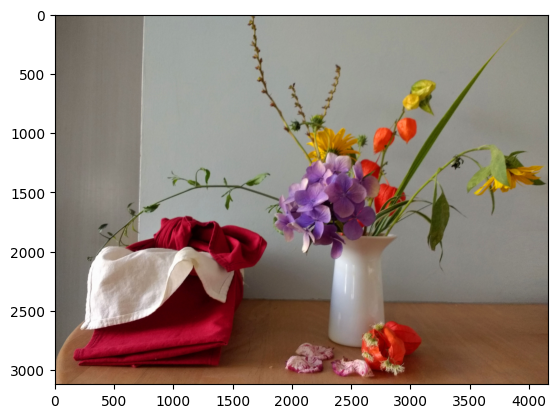

In [9]:
path = cv2.imread("flowers.jpg")[...,::-1]
plt.imshow(path)

## 推論

In [ ]:
TEXT_PROMPT = "purple flower"
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image("flowers.jpg")

boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)
print(boxes)
print(logits)
print(phrases)

tensor([[0.5526, 0.5174, 0.2174, 0.2885]])
tensor([0.6479])
['purple flower']


## 後処理

モデルが出力するbboxのフォーマットはcx, cy, w, h（中心座標＋大きさ）であるため、torchvisionのライブラリを使用して座標変換を行います。

In [ ]:
h, w, _ = image_source.shape
boxes = boxes * torch.Tensor([w, h, w, h])
xyxy = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()
print(xyxy)

[[1846.7625 1164.1112 2751.1228 2064.2505]]


torchvisionのライブラリを使わず検出座標を変換すると下記のように表現することができます。

In [ ]:
#上のセルを実行した場合はこのセルを実行しないこと

import numpy as np

# normalized CXCYWH in torch tensor
print(boxes)
# normalized CXCYWH in numpy
bboxes = boxes.cpu().numpy().copy()
print(bboxes)
# CXCYWH
bboxes[:,0] = [x[0] * image_source.shape[1] for x in bboxes]
bboxes[:,1] = [x[1] * image_source.shape[0] for x in bboxes]
bboxes[:,2] = [x[2] * image_source.shape[1] for x in bboxes]
bboxes[:,3] = [x[3] * image_source.shape[0] for x in bboxes]
print(bboxes)
# minx, miny, maxx, maxy
cx = bboxes[:,0]
cy = bboxes[:,1]
w = bboxes[:,2]
h = bboxes[:,3]
xyxy = np.array([
    [x-0.5*w for x in cx],
     [x-0.5*h for x in cy],
      [x+0.5*w for x in cx],
       [x+0.5*w for x in cy],
    ])
xyxy = xyxy.reshape(-1,4)
print(xyxy)

tensor([[0.5526, 0.5174, 0.2174, 0.2885]])
[[0.5526304  0.51736563 0.21739435 0.28850615]]
[[2298.9426  1614.1808   904.3605   900.13916]]
[[1846.7625 1164.1112 2751.1228 2066.361 ]]


## 描画
得られたbbbox座標をもとにcv2ライブラリを使用して画像に描画してもよいですが、ここではroboflowが提供するsupervisionを用いて描画します。
supervisionによる描画に必要な情報は、bboxのxyxy座標、クラスid、クラススコアの３つです。

In [ ]:
def convert_strings_to_ints(strings):
    unique_strings = list(set(strings))
    string_to_int = {string: idx for idx, string in enumerate(unique_strings)}
    result = [string_to_int[string] for string in strings]
    return result

In [ ]:
detections = sv.Detections.empty()
detections.xyxy = xyxy
detections.class_id = convert_strings_to_ints(phrases)

box_annotator = sv.BoundingBoxAnnotator(thickness=30)
label_annotator = sv.LabelAnnotator(text_scale=5, text_thickness=10)

annotated_frame = box_annotator.annotate(image_source.copy(), detections=detections)
annotated_frame = label_annotator.annotate(annotated_frame, detections=detections, labels=phrases)

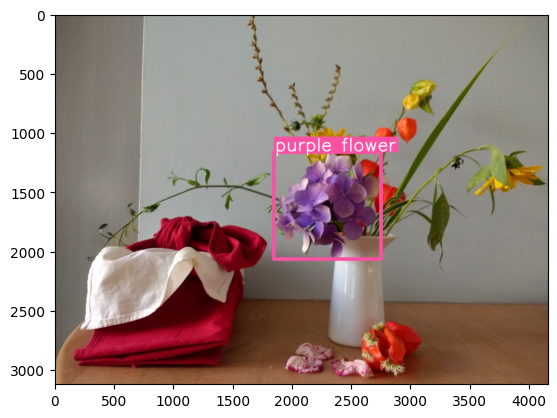

In [ ]:
plt.imshow(annotated_frame)

## 異なるプロンプトでの推論
TEXT_PROMPTに違うプロンプト（英語）を入れて、結果がどう変わるか試してみましょう。

In [ ]:
TEXT_PROMPT = "vase"
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image("flowers.jpg")

boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

h, w, _ = image_source.shape
boxes = boxes * torch.Tensor([w, h, w, h])
xyxy = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()

detections = sv.Detections.empty()
detections.xyxy = xyxy
detections.class_id = convert_strings_to_ints(phrases)

box_annotator = sv.BoundingBoxAnnotator(thickness=30)
label_annotator = sv.LabelAnnotator(text_scale=5, text_thickness=10)

annotated_frame = box_annotator.annotate(image_source.copy(), detections=detections)
annotated_frame = label_annotator.annotate(annotated_frame, detections=detections, labels=phrases)

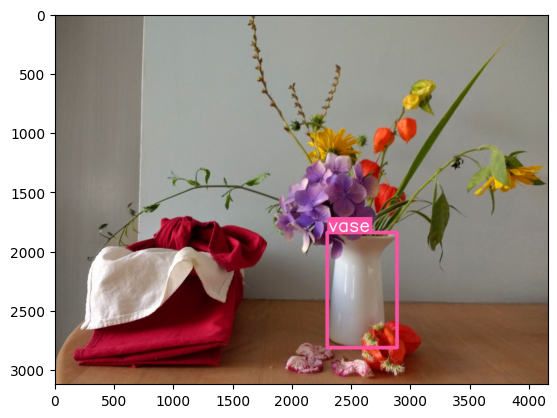

In [ ]:
plt.imshow(annotated_frame)